# Simulation 01a

# Using Stan for simulation

## Josep Fortiana  2023-02-27

***
###### LaTeX macros
$\def\prob{P}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\DeclareMathOperator{\indep}{\perp\negthickspace\negthinspace\perp}$
***

# Structure of a Stan program

Stan is a _probabilistic programming language,_ meaning  **it has probability distributions as primary objects**.

### Stan programs

Programs in Stan are ASCII text files.

Either standalone files which usually have the `.stan` extension

Or just as string objects in the calling environment (R or Python code or notebooks) directly sent to the interpreter as shown below.

### Blocks in a Stan program

Stan programs are organized in blocks. 

The following description is taken from _Stan Reference manual 2.29_:

```
functions {
// ... function declarations and definitions ...
}
data {
// ... declarations ...
}
transformed data {
// ... declarations ... statements ...
}
parameters {
// ... declarations ...
}
transformed parameters {
// ... declarations ... statements ...
}
model {
// ... declarations ... statements ...
}
generated quantities {
// ... declarations ... statements ...
}

```

The function-definition block `functions` contains user-defined functions.

The `data` block declares the required data for the model. 

The `transformed data` block allows the definition of constants and transforms of the data. 

The `parameters` block declares the model's parameters — the unconstrained version of the parameters is what's sampled or optimized. 

The `transformed parameters` block allows variables to be defined in terms of data and parameters that may be used later and will be saved. 

The `model` block is where the log probability function is defined. 

The `generated quantities` block allows derived quantities based on parameters, data, and optionally (pseudo) random number generation. 

These blocks may be empty. 

For instance, `generated quantities` is the only strictly required block for the purpose of just generating random numbers which is what we will do today   
(yes, this is using a sledgehammer to crack nuts but, of course, the main goal is to get acquainted with the language and auxiliary tools).

# Loading `rstan` 

The R package to communicate with Stan.

In [1]:
#install.packages("rstan", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(rstan,quietly=TRUE)


rstan version 2.26.13 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file



In [2]:
# Following directions:
# For execution on a local, multicore CPU with excess RAM we recommend calling
# options(mc.cores = parallel::detectCores()).
# To avoid recompilation of unchanged Stan programs, we recommend calling
# rstan_options(auto_write = TRUE)
parallel::detectCores()
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

[1] 12

# 1. A first program: generate uniform random numbers

Random number generator function names in Stan are formed from the distribution name plus the suffix `_rng`. For instance:

`uniform_rng(reals alpha, reals beta)`

`beta_rng(reals alpha, reals beta)`

`normal_rng(reals mu, reals sigma)`

Here we generate uniform random numbers. 

We need only the `generated_quantities` block.

## 01 - Write Stan code

In [3]:
Unif_modelString <- "
    //functions {}
    //data{ }
    transformed data {}
    parameters{}
    transformed parameters {}
    model{ }
    generated quantities{
        real y=uniform_rng(0,1);
        }
"

## 02 - Generate a DSO

(A Dynamic Shared Object, e.g., a DLL in Windows)

### 02a - Either translate first the model to C++

In [4]:
Unif_stan_cpp <- stanc( model_code=Unif_modelString ) 

In [5]:
str(Unif_stan_cpp)

List of 5
 $ status       : logi TRUE
 $ model_cppname: chr "model1de045576789_file1de04ed5549f"
 $ cppcode      : chr "#ifndef USE_STANC3\n#define USE_STANC3\n#endif\n// Code generated by stanc v2.26.1-1-g67504470\n#include <stan/"| __truncated__
 $ model_name   : chr "file1de04ed5549f"
 $ model_code   : chr "    //functions {}\n    //data{ }\n    transformed data {}\n    parameters{}\n    transformed parameters {}\n  "| __truncated__
  ..- attr(*, "model_name2")= chr "file1de04ed5549f"


If we want to see the cpp code (it is essentially unreadable)

In [6]:
writeLines(Unif_stan_cpp$cppcode,"Unif_Stan.cpp")

### $\dots$ and then compile cpp code to DSO

In [7]:
Unif_stan_DSO_a <- stan_model( stanc_ret=Unif_stan_cpp ) 

In [8]:
str(Unif_stan_DSO_a)

Formal class 'stanmodel' [package "rstan"] with 5 slots
  ..@ model_name  : chr "file1de04ed5549f"
  ..@ model_code  : chr "    //functions {}\n    //data{ }\n    transformed data {}\n    parameters{}\n    transformed parameters {}\n  "| __truncated__
  .. ..- attr(*, "model_name2")= chr "file1de04ed5549f"
  ..@ model_cpp   :List of 2
  .. ..$ model_cppname: chr "model1de045576789_file1de04ed5549f"
  .. ..$ model_cppcode: chr "#ifndef MODELS_HPP\n#define MODELS_HPP\n#define STAN__SERVICES__COMMAND_HPP\n#include <rstan/rstaninc.hpp>\n#if"| __truncated__
  ..@ mk_cppmodule:function (object)  
  ..@ dso         :Formal class 'cxxdso' [package "rstan"] with 7 slots
  .. .. ..@ sig         :List of 1
  .. .. .. ..$ file1de010e355c3: chr(0) 
  .. .. ..@ dso_saved   : logi TRUE
  .. .. ..@ dso_filename: chr "file1de010e355c3"
  .. .. ..@ modulename  : chr "stan_fit4model1de045576789_file1de04ed5549f_mod"
  .. .. ..@ system      : chr "x86_64, mingw32"
  .. .. ..@ cxxflags    : chr "CXXFLAGS =

A `.dll` file named `dso_filename` is created in the temp folder:

In [9]:
Sys.getenv("TEMP")

[1] "C:\\Users\\josep\\AppData\\Local\\Temp"

### 02b - Directly do both: translate model to C++ and compile to DSO

Usually we do not need the C++ code. Possibly only for debugging.

In [10]:
Unif_stan_DSO_b <- stan_model( model_code=Unif_modelString ) 

In [11]:
str(Unif_stan_DSO_b)

Formal class 'stanmodel' [package "rstan"] with 5 slots
  ..@ model_name  : chr "file1de04ed5549f"
  ..@ model_code  : chr "    //functions {}\n    //data{ }\n    transformed data {}\n    parameters{}\n    transformed parameters {}\n  "| __truncated__
  .. ..- attr(*, "model_name2")= chr "file1de04ed5549f"
  ..@ model_cpp   :List of 2
  .. ..$ model_cppname: chr "model1de045576789_file1de04ed5549f"
  .. ..$ model_cppcode: chr "#ifndef MODELS_HPP\n#define MODELS_HPP\n#define STAN__SERVICES__COMMAND_HPP\n#include <rstan/rstaninc.hpp>\n#if"| __truncated__
  ..@ mk_cppmodule:function (object)  
  ..@ dso         :Formal class 'cxxdso' [package "rstan"] with 7 slots
  .. .. ..@ sig         :List of 1
  .. .. .. ..$ file1de010e355c3: chr(0) 
  .. .. ..@ dso_saved   : logi TRUE
  .. .. ..@ dso_filename: chr "file1de010e355c3"
  .. .. ..@ modulename  : chr "stan_fit4model1de045576789_file1de04ed5549f_mod"
  .. .. ..@ system      : chr "x86_64, mingw32"
  .. .. ..@ cxxflags    : chr "CXXFLAGS =

## 03 - Enter data (if any), specify runtime quantities (if any), and execute the code

For this model, the sampler must be configured to use the `"Fixed_parameters"` setting because there are no parameters. 

Without parameter sampling there is no need for adaptation and the number of warmup iterations should be set to zero   
(See section 15.3. _Sampling without parameters_ in the Reference manual, pag. 180).

In [13]:
# Specify data:
dataList <- NULL

In [14]:
# Generate posterior sample:
Unif_stanFit <- sampling( object=Unif_stan_DSO_a, 
                     data = dataList, algorithm="Fixed_param",
                     chains = 1, seed = 24056, iter = 4000, warmup = 0, thin = 1)


SAMPLING FOR MODEL 'file1de04ed5549f' NOW (CHAIN 1).
Chain 1: Iteration:    1 / 4000 [  0%]  (Sampling)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Sampling)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Sampling)
Chain 1: Iteration: 1200 / 4000 [ 30%]  (Sampling)
Chain 1: Iteration: 1600 / 4000 [ 40%]  (Sampling)
Chain 1: Iteration: 2000 / 4000 [ 50%]  (Sampling)
Chain 1: Iteration: 2400 / 4000 [ 60%]  (Sampling)
Chain 1: Iteration: 2800 / 4000 [ 70%]  (Sampling)
Chain 1: Iteration: 3200 / 4000 [ 80%]  (Sampling)
Chain 1: Iteration: 3600 / 4000 [ 90%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.003 seconds (Sampling)
Chain 1:                0.003 seconds (Total)
Chain 1: 


## The resulting `stanFit` object contains all the information

The line below is usually commented due to its long output

In [15]:
str(Unif_stanFit)

Formal class 'stanfit' [package "rstan"] with 10 slots
  ..@ model_name: chr "file1de04ed5549f"
  ..@ model_pars: chr [1:2] "y" "lp__"
  ..@ par_dims  :List of 2
  .. ..$ y   : num(0) 
  .. ..$ lp__: num(0) 
  ..@ mode      : int 0
  ..@ sim       :List of 12
  .. ..$ samples    :List of 1
  .. .. ..$ :List of 2
  .. .. .. ..$ y   : num [1:4000] 0.0296 0.5901 0.8318 0.455 0.0172 ...
  .. .. .. ..$ lp__: num [1:4000] 0 0 0 0 0 0 0 0 0 0 ...
  .. .. .. ..- attr(*, "test_grad")= logi FALSE
  .. .. .. ..- attr(*, "args")=List of 16
  .. .. .. .. ..$ append_samples    : logi FALSE
  .. .. .. .. ..$ chain_id          : num 1
  .. .. .. .. ..$ control           :List of 11
  .. .. .. .. .. ..$ adapt_delta      : num 0.8
  .. .. .. .. .. ..$ adapt_engaged    : logi FALSE
  .. .. .. .. .. ..$ adapt_gamma      : num 0.05
  .. .. .. .. .. ..$ adapt_init_buffer: num 75
  .. .. .. .. .. ..$ adapt_kappa      : num 0.75
  .. .. .. .. .. ..$ adapt_t0         : num 10
  .. .. .. .. .. ..$ adapt_term_bu

## 04 - Extract random numbers

In [16]:
Unif_Rnd<-extract(Unif_stanFit)
str(Unif_Rnd)

List of 2
 $ y   : num [1:4000(1d)] 0.766 0.258 0.822 0.825 0.614 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 $ lp__: num [1:4000(1d)] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL


In [17]:
y<-extract(Unif_stanFit,par="y")
str(y)

List of 1
 $ y: num [1:4000(1d)] 0.766 0.258 0.822 0.825 0.614 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL


In [18]:
y<-extract(Unif_stanFit,par="y")$y
str(y)

 num [1:4000(1d)] 0.766 0.258 0.822 0.825 0.614 ...
 - attr(*, "dimnames")=List of 1
  ..$ iterations: NULL


In [19]:
# Discard the unneeded attribute
attr(y,"dimnames")<-NULL
str(y)

 num [1:4000(1d)] 0.766 0.258 0.822 0.825 0.614 ...


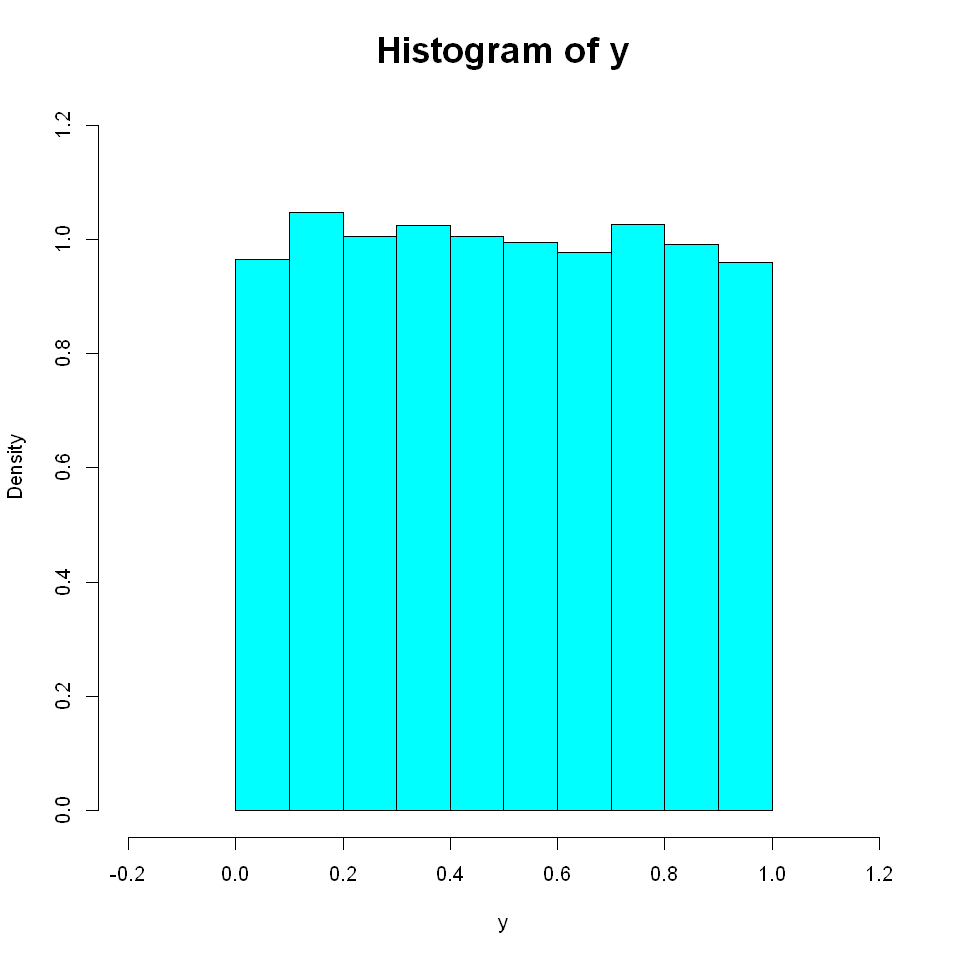

In [20]:
options(repr.plot.width=8,repr.plot.height=8)
hist(y,freq=FALSE,col="cyan",xlim=c(-0.2,1.2), ylim=c(0,1.2),cex.main=1.8)

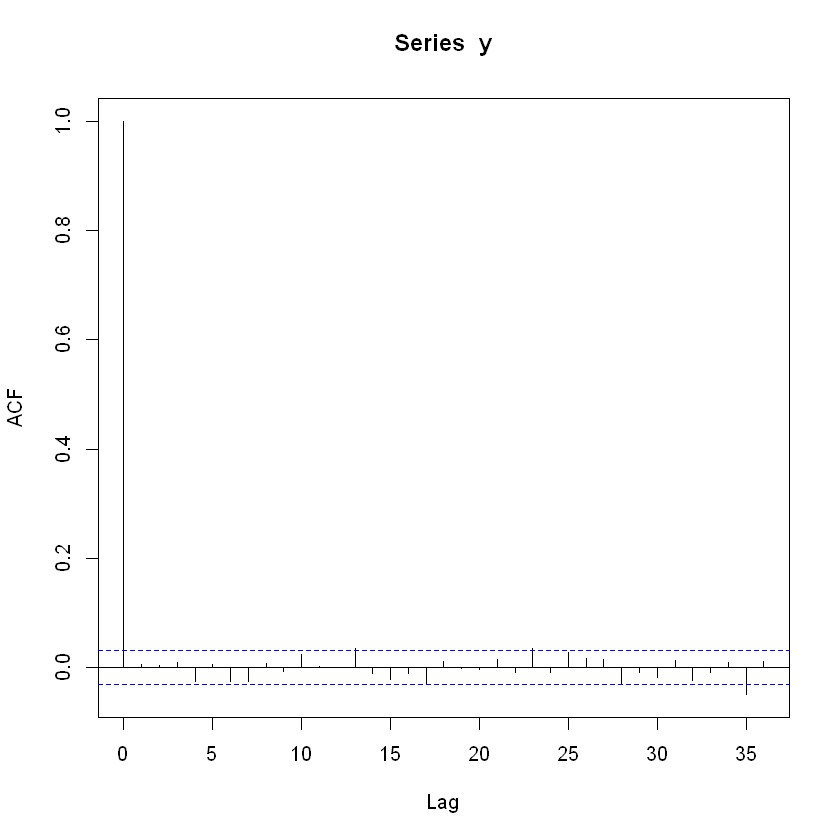

In [20]:
acf(y)

# 2. A second example: random $\gammadist(\alpha,\beta)$ numbers

$$
    \gammadist(y|\alpha,\beta) = \dfrac{\beta^{\alpha}}{\Gamma(\alpha)}\,y^{\alpha-1}\,\exp(-\beta\,y).
$$

## 01 - Write Stan code

Now the function to use is: `gamma_rng(reals alpha, reals beta)`.

$\alpha$ and $\beta$ are declared in the data block.

We will enter numerical values for $\alpha$ and $\beta$ at runtime

In [21]:
Gamma_modelString <- "
    //functions {}
    data{
        real<lower=0> alpha;
        real<lower=0> beta;
        }
    transformed data {}
    parameters{}
    transformed parameters {}
    model{ }
    generated quantities{
        real y=gamma_rng(alpha,beta);
        }
"

## 02 - Compile to DSO

In [22]:
Gamma_stanDso <- stan_model( model_code=Gamma_modelString ) 
str(Gamma_stanDso)

Formal class 'stanmodel' [package "rstan"] with 5 slots
  ..@ model_name  : chr "anon_model"
  ..@ model_code  : chr "    //functions {}\n    data{\n        real<lower=0> alpha;\n        real<lower=0> beta;\n        }\n    transf"| __truncated__
  .. ..- attr(*, "model_name2")= chr "96da8e9d8a26eb07c9caaf8839d531ac"
  ..@ model_cpp   :List of 2
  .. ..$ model_cppname: chr "model1de066df2571_"
  .. ..$ model_cppcode: chr "#ifndef MODELS_HPP\n#define MODELS_HPP\n#define STAN__SERVICES__COMMAND_HPP\n#include <rstan/rstaninc.hpp>\n#if"| __truncated__
  ..@ mk_cppmodule:function (object)  
  ..@ dso         :Formal class 'cxxdso' [package "rstan"] with 7 slots
  .. .. ..@ sig         :List of 1
  .. .. .. ..$ file1de07c27653: chr(0) 
  .. .. ..@ dso_saved   : logi TRUE
  .. .. ..@ dso_filename: chr "file1de07c27653"
  .. .. ..@ modulename  : chr "stan_fit4model1de066df2571__mod"
  .. .. ..@ system      : chr "x86_64, mingw32"
  .. .. ..@ cxxflags    : chr "CXXFLAGS = -O2 -Wall $(DEBUGFLAG) 

## 03 - Specify runtime quantities and execute the code

For this model, the sampler must be configured to use the `"fixed-parameters"` setting because there are no parameters. 

Without parameter sampling there is no need for adaptation and the number of warmup iterations should be set to zero    
(See section 15.3. _Sampling without parameters_ in the Reference manual).

In [23]:
# Specify data:
a <-2
b <-4
Gamma_dataList <- list("alpha" = a, "beta" = b)

In [24]:
# Generate posterior sample:
Gamma_stanFit <- sampling( object=Gamma_stanDso, 
                     data = Gamma_dataList, algorithm="Fixed_param",
                     chains = 1, seed = 24056, iter = 10000, warmup = 0, thin = 1)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: Iteration:    1 / 10000 [  0%]  (Sampling)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Sampling)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Sampling)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Sampling)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Sampling)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.01 seconds (Sampling)
Chain 1:                0.01 seconds (Total)
Chain 1: 


## 04 - Extract random numbers

In [25]:
y<-extract(Gamma_stanFit,par="y")$y
# Discard the unneeded attribute
attr(y,"dimnames")<-NULL
str(y)

 num [1:10000(1d)] 0.477 1.097 0.141 1.046 0.159 ...


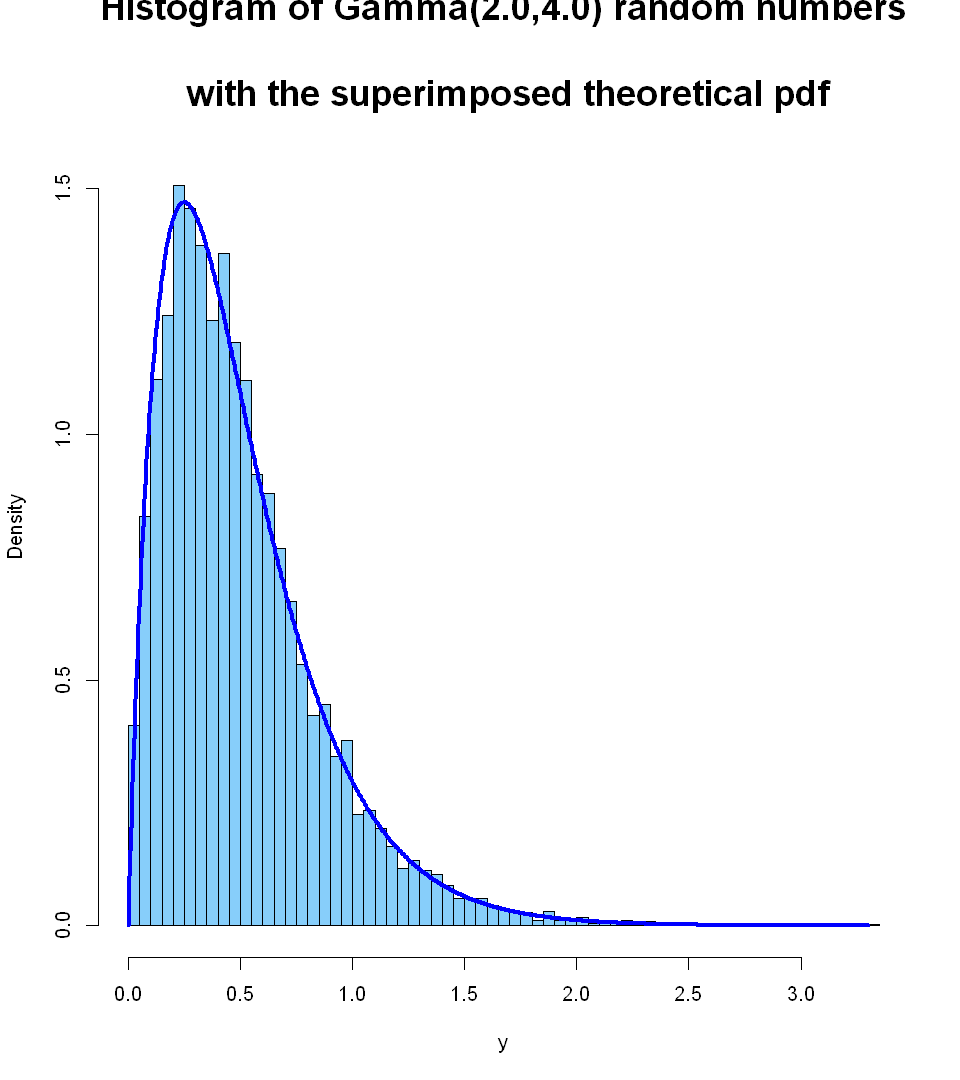

In [27]:
y.max<-max(y)
u<-seq(0,y.max,length=1000)
df.theor<-dgamma(u,shape=a,rate=b)
f.max<-max(df.theor)
options(repr.plot.width=8,repr.plot.height=9)
hist(y,freq=FALSE,col="LightSkyBlue",ylim=c(0,f.max*1.1),main=sprintf("Histogram of Gamma(%2.1f,%2.1f) random numbers
    \n with the superimposed theoretical pdf",a,b),nclass=50,cex.main=1.8)
lines(u,df.theor,lwd=3.5,col="blue")